In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from helper import plot_mnist

# Notes

- maybe it's a good idea to keep some learning goals in the introduction? 

  """By the end of this notebook, you will be able to:
  - Apply clustering techniques to both image and healthcare data
  - Interpret clustering results and evaluate their quality
  - Understand how clustering - support data-driven decision-making in healthcare

  Let's get started!
  """
- I changed the dataset to the Wine Dataset, for faster computation, less datapoints etc. 
- K-means already performs really well, which does not show the usefulness of K-Medoids
- I also applied the clustering algorithms on the UMAP reduced data instead for cleaner results. We - change this if we like, should maybe try the other option too but do it at the end
- TODO: Adjust the Header sizes
- I had some trouble looking for good datasets, now going with breast cancer wisconsin, however it's only 2 groups.
- The method to choose a good epsilon in DBSCAN is somewhat not reliable in the Wine example, because a higher epsilon obviously worked better

# Table of Contents

<br><br>
# **Hands-On: Clustering**

In this Hands-On session, we will explore clustering, an essential unsupervised learning technique that helps us discover patterns and structure within complex datasets. Clustering algorithms - group similar data points together without any prior labels, making them invaluable for exploratory data analysis, anomaly detection, and patient stratification in healthcare.

To build a strong foundation, we will start with a new dataset on wines. Once comfortable with the techniques, we will transfer our knowledge to a real-world healthcare dataset, examining how clustering - reveal meaningful subgroups and insights in clinical data.

Let's get started!

## Introduction to the Wine Dataset

The **Wine Recognition dataset** is a classic dataset in machine learning, containing chemical analysis results of wines grown in the same region of Italy but derived from three different cultivars (grape varieties).

- **Samples:** 178 wine samples
- **Features:** 13 numeric features representing chemical properties (for example alcohol content, color intensity, flavanoids etc.)
- **Labels:** 
    - `0` = Class 0 wine (59 samples)
    - `1` = Class 1 wine (71 samples) 
    - `2` = Class 2 wine (48 samples)
- **Data type:** All features are continuous, numeric (floating-point)
- **No missing values:** The dataset is complete and ready for analysis
- **Why useful for clustering:** The three wine classes have distinct chemical profiles, making them ideal for demonstrating how clustering algorithms - discover natural groupings in data

The chemical analysis approach mirrors how we might cluster patients based on blood tests, metabolic panels, or other laboratory measurements in healthcare settings.

In [55]:
# Load the Wine dataset
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

# Load the dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  wine_

In [23]:
df.describe().round(2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89,0.94
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91,0.78
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00,0.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50,0.00
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50,1.00
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00,2.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00,2.00


In [24]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
wine_class                      0
dtype: int64

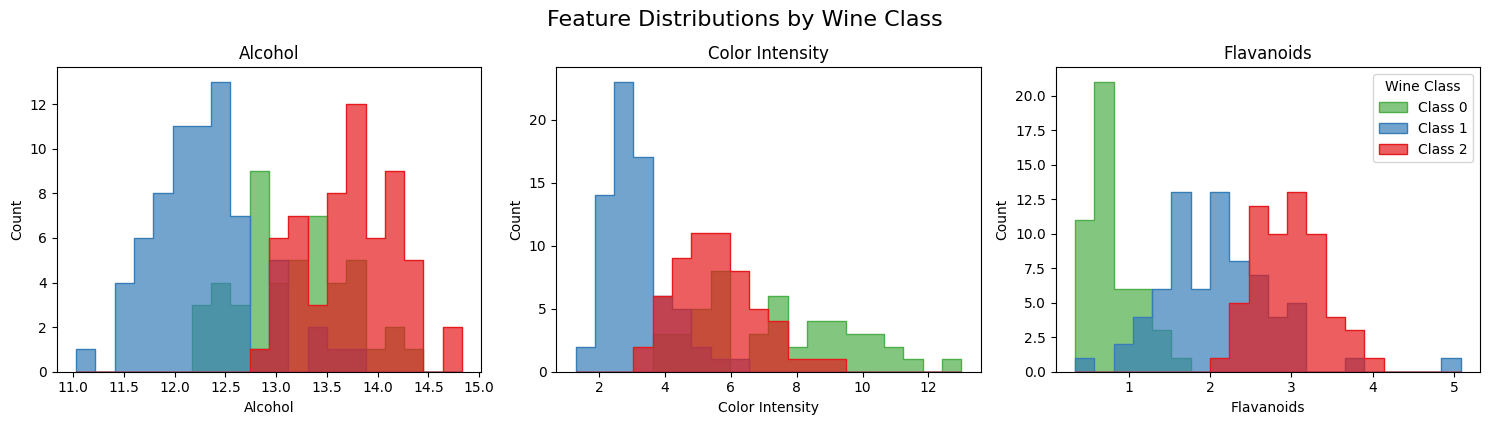

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame for easier plotting
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

# Visualize distributions of key features, colored by wine class
plt.figure(figsize=(15, 4))
for i, feat in enumerate(['alcohol', 'color_intensity', 'flavanoids']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feat, hue='wine_class', palette='Set1', bins=20, alpha=0.7, 
                 legend=(i==2), element="step")
    plt.title(feat.replace('_', ' ').title())
    plt.xlabel(feat.replace('_', ' ').title())
    plt.ylabel('Count')
    if i == 2:
        plt.legend(labels=[f'Class {i}' for i in range(3)], title='Wine Class')
plt.tight_layout()
plt.suptitle("Feature Distributions by Wine Class", fontsize=16, y=1.05)
plt.show()

# K-Means/K-Medoids Clustering

**K-Means Clustering** is a simple approach for partitioning a dataset into *K* distinct, non-overlapping clusters.

### Key Characteristics:
- **Must specify K beforehand** - You need to decide how many clusters to find
- **Centroid-based** - Each cluster is represented by its center point (centroid)
- **Iterative algorithm** - Repeats steps until convergence
- **Assumes spherical clusters** - Works best when clusters are roughly round and similar sizes

### How K-Means Works:

**Step 1: Initialize**
- Choose *K* random starting points as initial cluster centroids
- Common methods: random points, K-means++ (smarter initialization)

**Step 2: Assignment**
- For each data point, calculate distance to all centroids
- Assign each point to the closest centroid's cluster

**Step 3: Update**
- Calculate the mean (centroid) of all points in each cluster
- Move the centroid to this new mean position

**Step 4: Repeat**
- Repeat steps 2-3 until convergence:
  - Centroids stop moving signifi-tly, OR
  - Cluster assignments stop changing, OR
  - Maximum iterations reached

### For Our Wine Dataset:
- We know there are **K=3** wine classes (different grape cultivars)
- K-Means should discover these 3 natural groups based on chemical properties
- We'll see if the algorithm - separate wines without knowing the true labels!

Let's see how well K-Means performs on our Wine dataset and visualize the clustering process step by step!

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


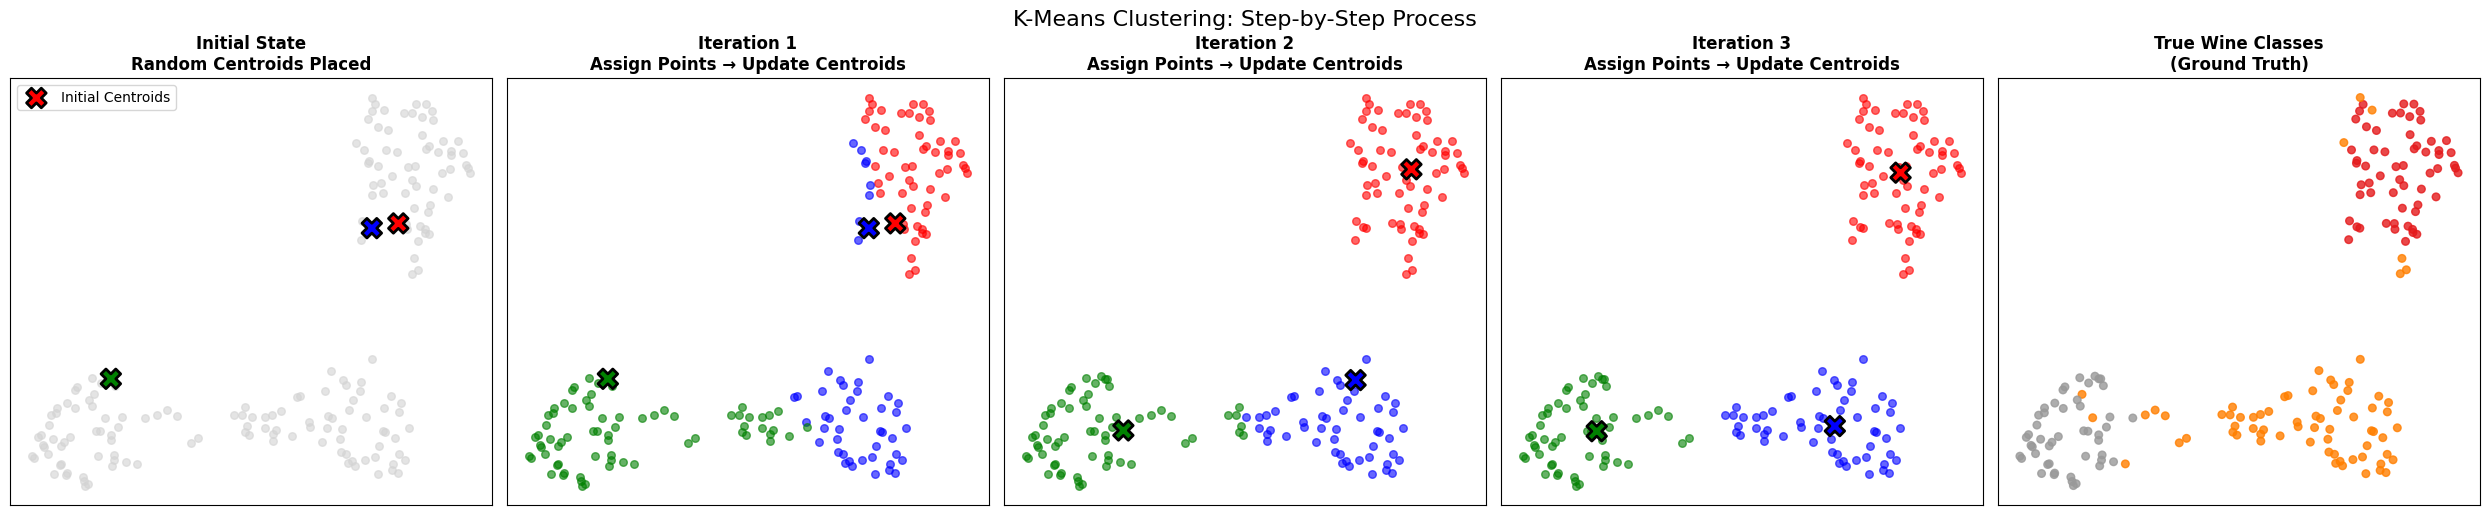

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for 2D visualization
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

# Manual K-Means implementation for step-by-step visualization
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def assign_clusters(X, centroids):
    clusters = []
    for point in X:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def update_centroids(X, clusters, k):
    centroids = []
    for i in range(k):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
        else:
            centroid = X[np.random.randint(0, len(X))]  # Handle empty clusters
        centroids.append(centroid)
    return np.array(centroids)

# Initialize K=3 random centroids
np.random.seed(42)
k = 3
initial_centroids = X_umap[np.random.choice(X_umap.shape[0], k, replace=False)]

# Colors for visualization
colors = ['red', 'blue', 'green']

# Step-by-step K-Means
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

centroids = initial_centroids.copy()

for iteration in range(5):  # 0=initial, 1-3=iterations, 4=true classes
    
    if iteration == 0:
        # Initial state
        axes[iteration].scatter(X_umap[:, 0], X_umap[:, 1], c='lightgray', s=30, alpha=0.6)
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=200, marker='X', 
                              edgecolors='black', linewidth=2, label='Initial Centroids')
        axes[iteration].set_title(f'Initial State\nRandom Centroids Placed', fontsize=12, fontweight='bold')
        axes[iteration].legend()
    elif iteration <= 3:
        # Assign points to clusters
        clusters = assign_clusters(X_umap, centroids)
        
        # Plot points colored by cluster assignment
        for i in range(k):
            mask = clusters == i
            axes[iteration].scatter(X_umap[mask, 0], X_umap[mask, 1], c=colors[i], s=30, alpha=0.6)
        
        # Plot centroids
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=200, marker='X', 
                              edgecolors='black', linewidth=2)
        
        axes[iteration].set_title(f'Iteration {iteration}\nAssign Points → Update Centroids', 
                                fontsize=12, fontweight='bold')
        
        # Update centroids for next iteration
        if iteration < 3:
            centroids = update_centroids(X_umap, clusters, k)
    else:
        # Show true wine classes for comparison
        axes[iteration].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Set1', s=30, alpha=0.8)
        axes[iteration].set_title('True Wine Classes\n(Ground Truth)', fontsize=12, fontweight='bold')
    
    axes[iteration].set_xticks([])
    axes[iteration].set_yticks([])
    axes[iteration].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('K-Means Clustering: Step-by-Step Process', fontsize=16, y=1.02)
plt.show()

**Key Observations**:
- Centroids move toward the center of their assigned points
- Already after 3 iterations, the resulting clusters look very similar to the Ground Truth!

Let's use KMeans now with the *Scikit-learn* package!

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


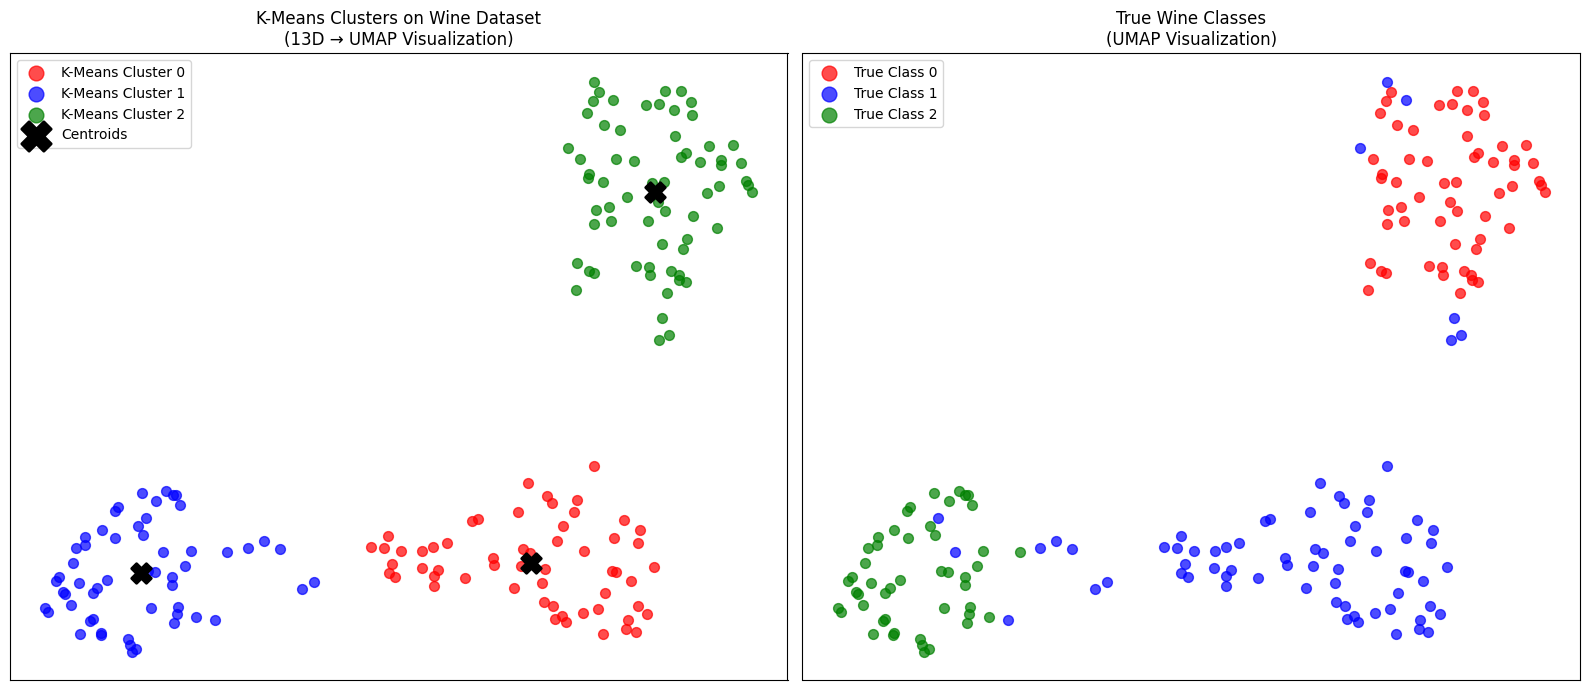

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# TODO Remove this code block because we used it before

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for visualization
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

# K-Means clustering on original high-dimensional data (13 features)
kmeans = KMeans(n_clusters=3, random_state=42,)
kmeans.fit(X_umap)  # Cluster on original 13D data

# Prepare colors for 3 clusters/classes
colors = ['red', 'blue', 'green']
wine_class_names = ['Class 0', 'Class 1', 'Class 2']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- K-Means subplot ---
for i in range(3):
    idx = kmeans.labels_ == i
    axs[0].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"K-Means Cluster {i}")

# Plot cluster centroids projected to UMAP space
centroids_umap = kmeans.cluster_centers_ #umap.transform(kmeans.cluster_centers_)
axs[0].scatter(centroids_umap[:, 0], centroids_umap[:, 1], 
               c='black', marker='X', s=200, linewidth=2, label='Centroids')

axs[0].set_title('K-Means Clusters on Wine Dataset\n(13D → UMAP Visualization)', fontsize=12)
axs[0].legend(markerscale=1.5)

# --- True Labels subplot ---
for i in range(3):
    idx = y == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"True {wine_class_names[i]}")

axs[1].set_title('True Wine Classes\n(UMAP Visualization)', fontsize=12)
axs[1].legend(markerscale=1.5)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## From K-Means to K-Medoids

K-Means worked well, but let's explore **K-Medoids (PAM)** - a more robust alternative.

### Key Differences:

- **Cluster centers**: K-Means uses calculated centroids vs K-Medoids uses actual data points (medoids)
- **Outlier sensitivity**: K-Medoids is more robust to outliers than K-Means
- **Distance metrics**: K-Medoids - use any distance metric, K-Means is limited to Euclidean

### When to Use K-Medoids:

- **Noisy data** with outliers
- **Better interpretability** - medoids are real wine samples
- **Non-Euclidean data** where averaging doesn't make sense

Let's apply K-Medoids to our wine dataset and compare the results!

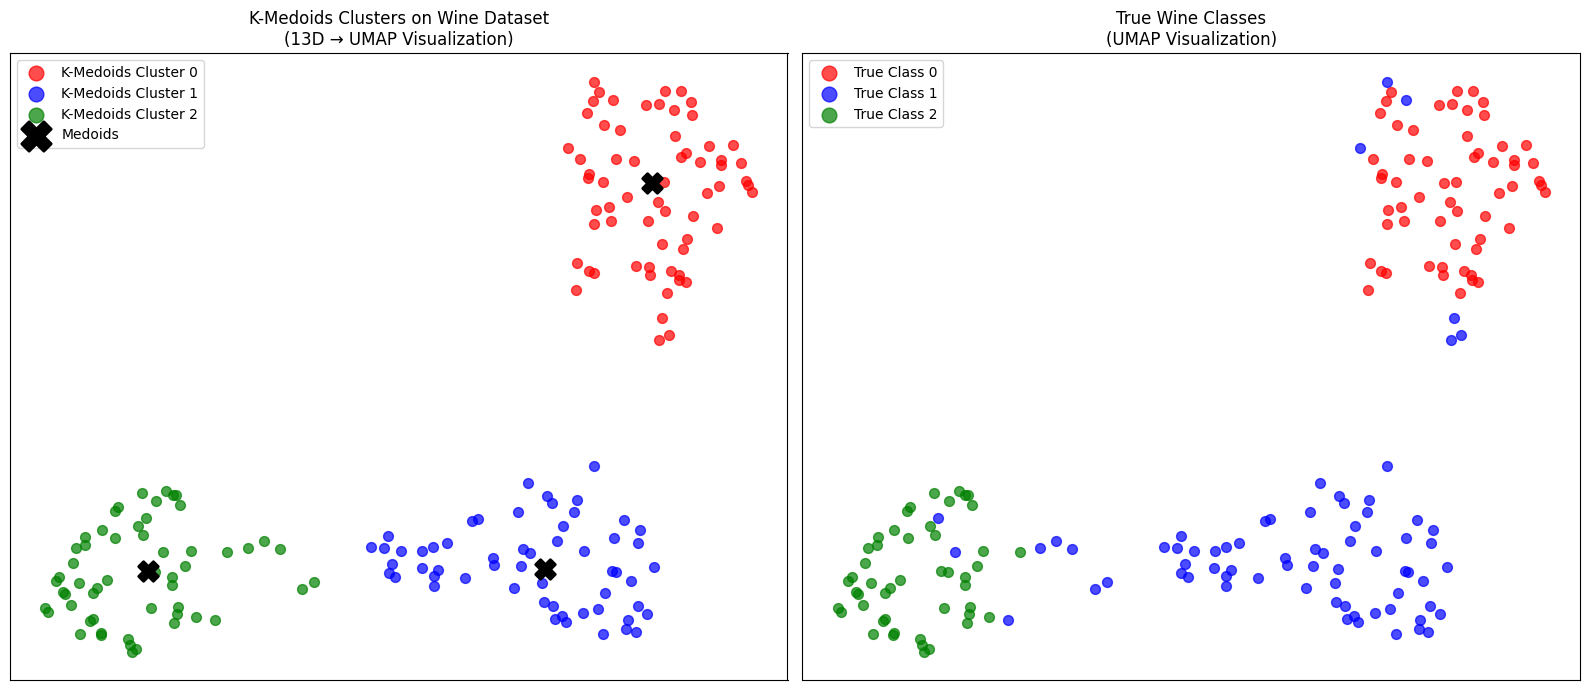

In [65]:
import kmedoids
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances, adjusted_rand_score, silhouette_score

# K-Medoids clustering on original high-dimensional data (13 chemical features)
kmed = kmedoids.KMedoids(n_clusters=3, random_state=42)
euclidean_dist = pairwise_distances(X_umap, metric='euclidean')

kmed.fit(euclidean_dist)

# Prepare colors for 3 clusters/classes
colors = ['red', 'blue', 'green']
wine_class_names = ['Class 0', 'Class 1', 'Class 2']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- K-Medoids subplot ---
for i in range(3):
    idx = kmed.labels_ == i
    axs[0].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"K-Medoids Cluster {i}")

# Plot medoids (actual wine samples that are cluster centers)
medoids_umap = X_umap[kmed.medoid_indices_]
axs[0].scatter(medoids_umap[:, 0], medoids_umap[:, 1], 
               c='black', marker='X', s=200, linewidth=2, label='Medoids')

axs[0].set_title('K-Medoids Clusters on Wine Dataset\n(13D → UMAP Visualization)', fontsize=12)
axs[0].legend(markerscale=1.5)

# --- True Labels subplot ---
for i in range(3):
    idx = y == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"True {wine_class_names[i]}")

axs[1].set_title('True Wine Classes\n(UMAP Visualization)', fontsize=12)
axs[1].legend(markerscale=1.5)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## K-Means vs K-Medoids: Comparison

### Similarities:
- Both are partitional clustering methods that divide data into K clusters
- Must specify K beforehand
- Iterative algorithms with assignment and update steps
- Sensitive to initialization and assume similar cluster sizes

### Key Differences:

| Aspect | K-Means | K-Medoids |
|--------|---------|-----------|
| **Cluster Centers** | Calculated centroids | Actual data points |
| **Outlier Sensitivity** | High | Low |
| **Distance Metrics** | Euclidean only | Any metric |
| **Speed** | Faster | Slower |
| **Interpretability** | Centroids may not exist | Medoids are real samples |

### When to Use:

**K-Means:**
- Large datasets (computational efficiency)
- Clean data without outliers
- All continuous features

**K-Medoids:**
- Noisy data with outliers
- Need interpretable cluster centers
- Mixed data types or non-Euclidean distances

### For Wine Dataset:
Both performed well due to clean data, moderate size, and well-separated chemical profiles. Choice depends on specific requirements.

# Hierarchical Clustering

K-Means and K-Medoids require specifying the number of clusters K beforehand. **Hierarchical Clustering** offers an alternative approach that discovers the cluster structure without needing to choose K in advance.

### Key Advantages:
- **No need to specify K** - Algorithm reveals natural cluster structure
- **Dendrogram visualization** - Tree-based representation shows relationships between all data points
- **Multiple granularities** - - extract different numbers of clusters from same result
- **Deterministic** - No random initialization, same result every time

### Types of Hierarchical Clustering:

**Agglomerative (Bottom-Up):**
- Start with each point as its own cluster
- Iteratively merge the two closest clusters
- Continue until all points are in one cluster
- Most common approach

**Divisive (Top-Down):**
- Start with all points in one cluster
- Iteratively split clusters into smaller ones
- Less common due to computational complexity

### How Agglomerative Clustering Works:

**Step 1: Initialize**
- Each data point starts as its own cluster (N clusters for N points)

**Step 2: Find Closest Clusters**
- Calculate distances between all cluster pairs
- Identify the two closest clusters

**Step 3: Merge**
- Combine the closest clusters into one
- Update distance matrix

**Step 4: Repeat**
- Continue merging until only one cluster remains
- Record the merge sequence in a dendrogram

There are different distance metrics that are used to compute hierarchical clusterings, in this context they are called *linkage*. We will look at 4 common ones next.

Let's see how hierarchical clustering reveals the structure in our wine dataset!

### Ward's Method

**Ward's linkage** is the most popular linkage criterion for hierarchical clustering because it creates compact, spherical clusters similar to K-Means.

#### How Ward's Method Works:
- **Objective**: Minimize the increase in within-cluster sum of squares (variance) when merging clusters
- **Strategy**: At each step, merge the two clusters that result in the smallest increase in total variance
- **Result**: Tends to create clusters of similar sizes with low internal variance
- **Balanced clusters** - Avoids creating very large or very small clusters

Now let's apply Ward's method to our wine dataset and learn how to read dendrograms!

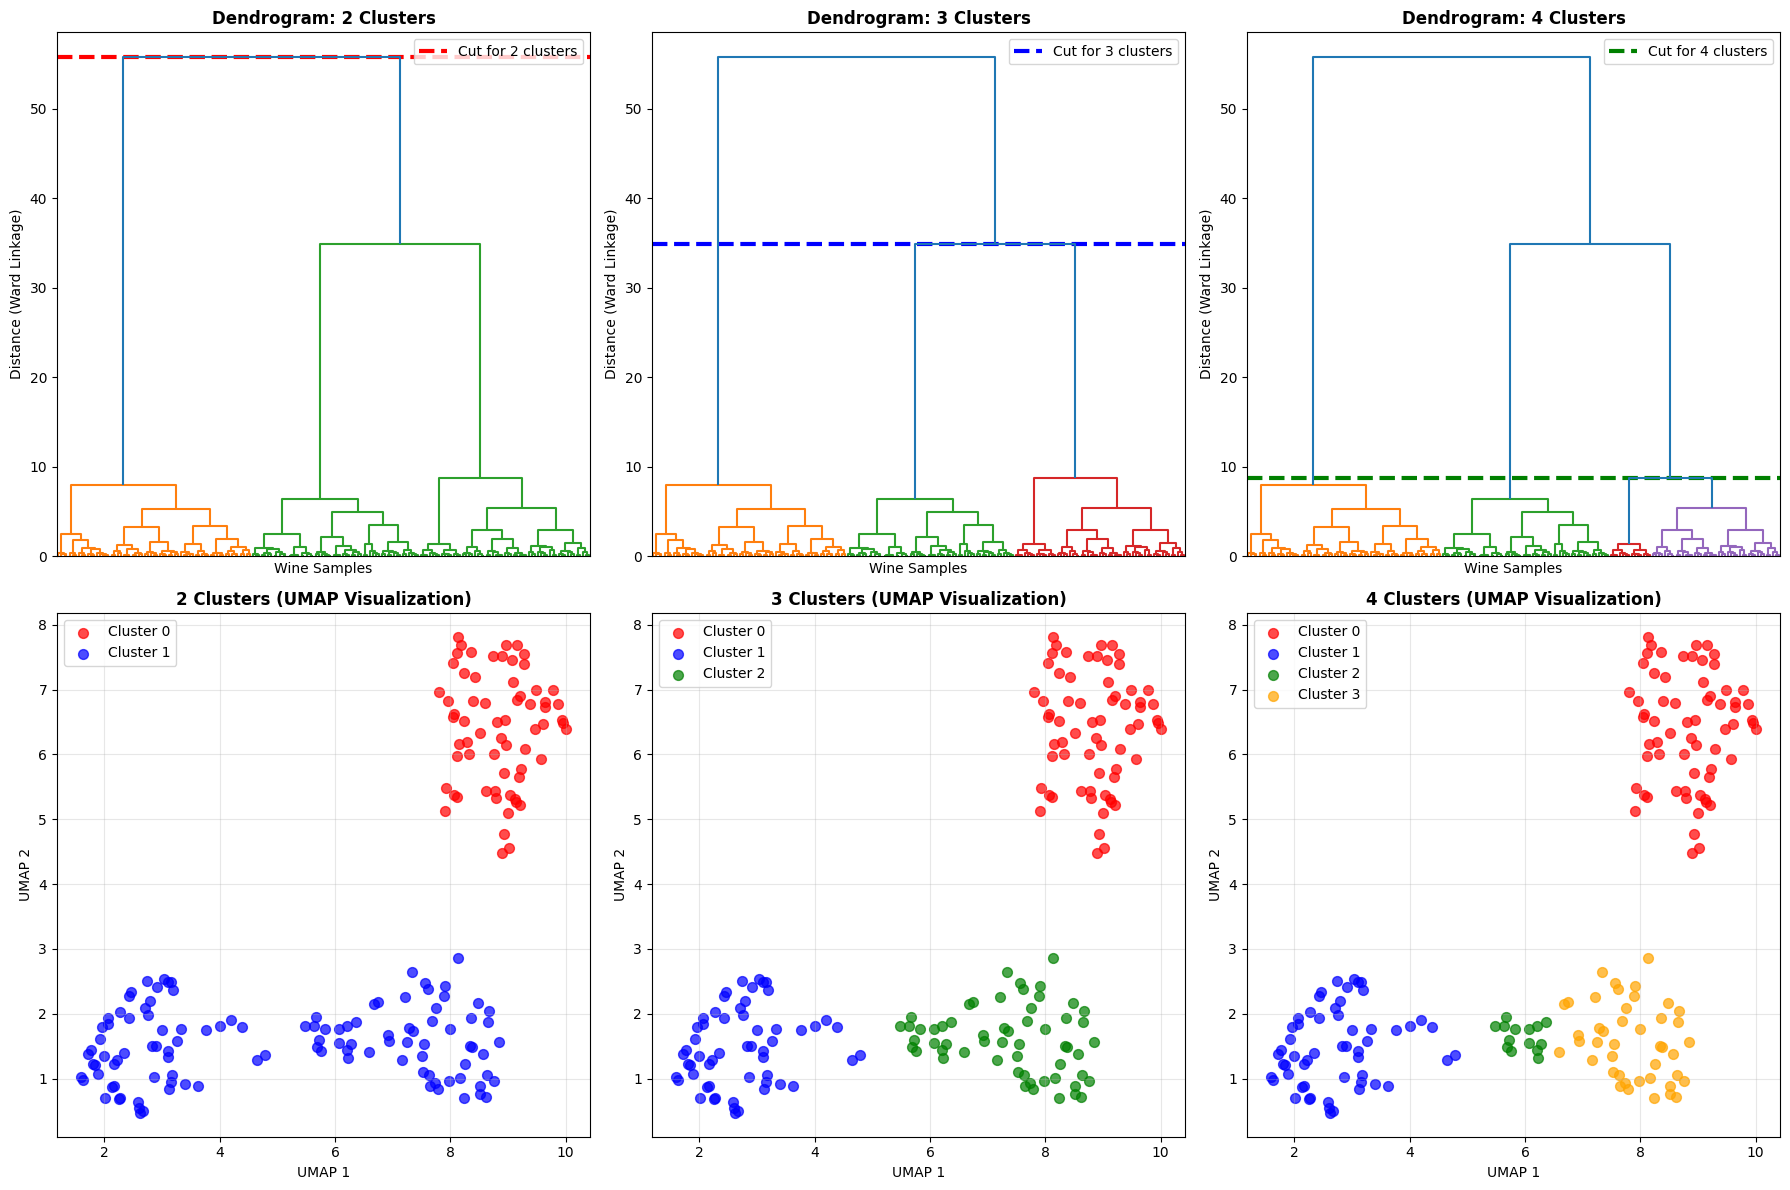

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

# Use standardized data for hierarchical clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_umap, method='ward')

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Three dendrograms with different cluster cuts
n_clusters_list = [2, 3, 4]
colors_cuts = ['red', 'blue', 'green']

for i, n_clusters in enumerate(n_clusters_list):
    ax = axes[0, i]
    
    # Find the distance threshold for n_clusters
    if n_clusters <= len(linkage_matrix):
        threshold = linkage_matrix[-(n_clusters-1), 2]
        ax.axhline(y=threshold, color=colors_cuts[i], linestyle='--', linewidth=3,
                  label=f'Cut for {n_clusters} clusters')
    
    # Create dendrogram
    dend = dendrogram(linkage_matrix, 
                     #truncate_mode='level', 
                     p=10,
                     leaf_rotation=90,
                     leaf_font_size=8,
                     show_leaf_counts=False,
                     color_threshold=threshold,
                     ax=ax)
    
    ax.set_title(f'Dendrogram: {n_clusters} Clusters', fontsize=12, fontweight='bold')
    ax.set_xlabel('Wine Samples', fontsize=10)
    ax.set_ylabel('Distance (Ward Linkage)', fontsize=10)
    ax.legend(loc='upper right')
    
    # Remove x-axis tick labels
    ax.set_xticks([])

# Bottom row: Cluster visualizations for 2, 3, 4 clusters
cluster_colors = ['red', 'blue', 'green', 'orange']

for i, n_clusters in enumerate([2, 3, 4]):
    ax = axes[1, i]
    
    # Get cluster labels for n_clusters
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1
    
    # Plot points colored by cluster
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                  c=cluster_colors[cluster_id], s=50, alpha=0.7,
                  label=f'Cluster {cluster_id}')
        
    if n_clusters == 3:
        # Store results for comparison
        ward_linkage_labels = cluster_labels
        ward_linkage_matrix = linkage_matrix
    
    ax.set_title(f'{n_clusters} Clusters (UMAP Visualization)', fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## How to Read Dendrograms

### Basic Structure:
- **Y-axis (Height)**: Distance at which clusters merge - higher means more dissimilar
- **X-axis**: Individual wine samples (numbers removed for clarity)
- **Branches**: Show the hierarchical relationship between samples and clusters
- **Colors**: Different colors represent different clusters at the cut level

### Key Elements:
- **Leaf nodes** (bottom): Individual wine samples
- **Internal nodes**: Points where clusters merge
- **Branch height**: Indicates similarity - shorter branches = more similar samples
- **Merge distance**: The height where two branches join

### Using the Cut Line:
- **Horizontal dashed line**: Shows where to "cut" the tree for desired number of clusters
- **Count clusters**: Number of vertical lines the cut line crosses
- **Cluster membership**: Samples connected below the cut belong to same cluster
- **Color coding**: Each cluster gets a different color below the cut line

### Choosing Optimal Number of Clusters:
- **Look for large jumps**: Big increases in merge distance suggest natural cluster boundaries
- **Avoid high cuts**: Don't cut where merge distances are very large
- **Compare solutions**: Use visualization plots to see which clustering makes most sense

For our Wine dataset, choosing 3 Clusters seem to provide a good fit, as there is a clear dissimalirity between the three groups.

## Single Linkage Method

**Single linkage** is the simplest linkage criterion for hierarchical clustering, based on the closest points between clusters.

### How Single Linkage Works:
- **Objective**: Merge clusters with the smallest minimum distance between any two points
- **Strategy**: At each step, find the two clusters whose closest points are nearest to each other
- **Result**: - create elongated, chain-like clusters that follow data patterns
- **Sensitive to outliers** - Single points - bridge distant clusters

Let's see how Single Linkage performs on our wine dataset!

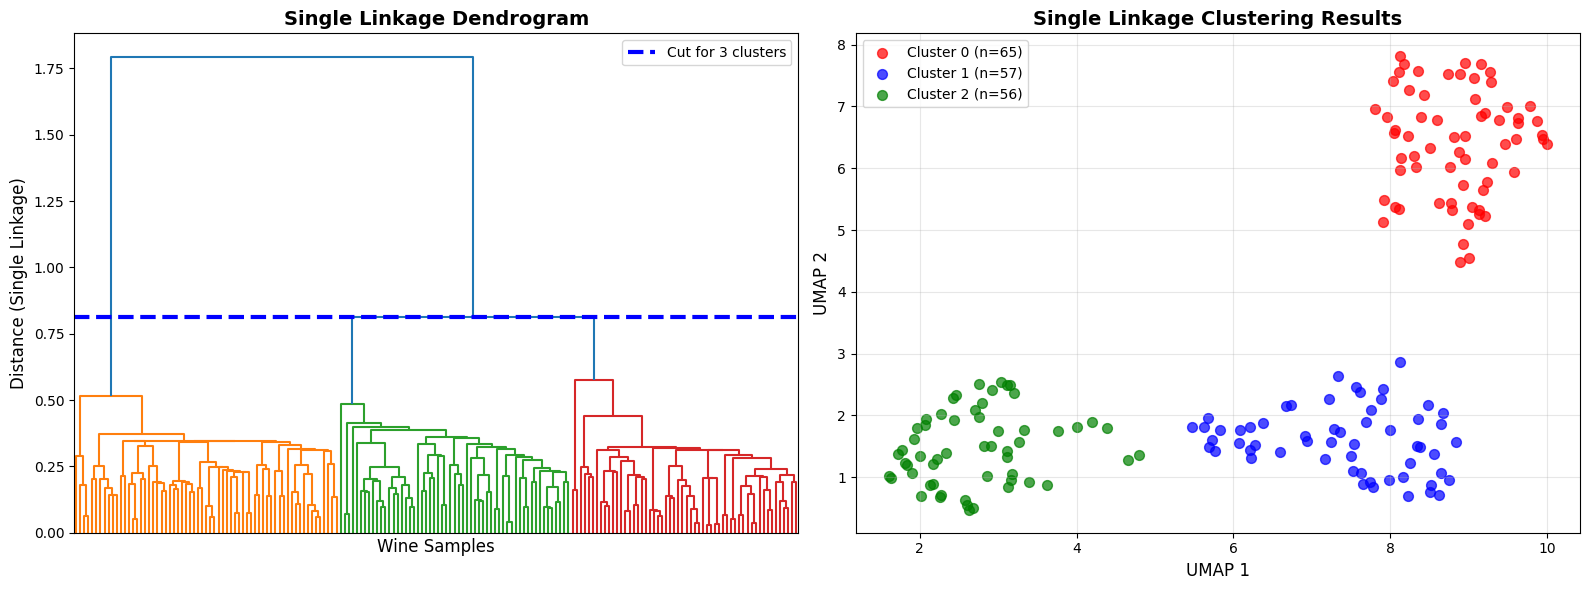

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Create linkage matrix using Single Linkage method
linkage_matrix_single = linkage(X_umap, method='single')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Single Linkage Dendrogram
ax1 = axes[0]
threshold_single = linkage_matrix_single[-(3-1), 2]  # For 3 clusters

dend_single = dendrogram(linkage_matrix_single, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_single,
                        ax=ax1)

ax1.axhline(y=threshold_single, color='blue', linestyle='--', linewidth=3,
           label='Cut for 3 clusters')
ax1.set_title('Single Linkage Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wine Samples', fontsize=12)
ax1.set_ylabel('Distance (Single Linkage)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Single Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_single = fcluster(linkage_matrix_single, 3, criterion='maxclust') - 1
cluster_colors = ['red', 'blue', 'green']

for cluster_id in range(3):
    mask = cluster_labels_single == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Single Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison
single_linkage_labels = cluster_labels_single
single_linkage_matrix = linkage_matrix_single

**Key Observations - Single Linkage Problems**:

- **Extreme imbalance**: One massive cluster (174 samples) vs tiny clusters (3 and 1 samples)
- **Chaining effect**: Forms long chains instead of compact, meaningful clusters  
- **Poor wine class separation**: Fails to identify the 3 natural wine varieties
- **Not suitable for spherical data**: Wine data has compact groups, but Single Linkage creates elongated connections

## Complete Linkage Method

**Complete linkage** (also called "farthest neighbor") is the opposite of single linkage, based on the most distant points between clusters.

### How Complete Linkage Works:
- **Objective**: Merge clusters with the smallest maximum distance between any two points
- **Strategy**: At each step, find the two clusters whose farthest points are closest to each other
- **Result**: Creates compact, tight clusters with similar diameters
- **Conservative merging** - Only merges clusters when even their most distant points are close

### Why Use Complete Linkage?
- **Compact clusters** - Produces spherical, well-separated clusters
- **Outlier resistant** - Less sensitive to outliers than single linkage
- **Balanced sizes** - Tends to create more evenly sized clusters than single linkage

Let's see how Complete Linkage performs on our wine dataset!

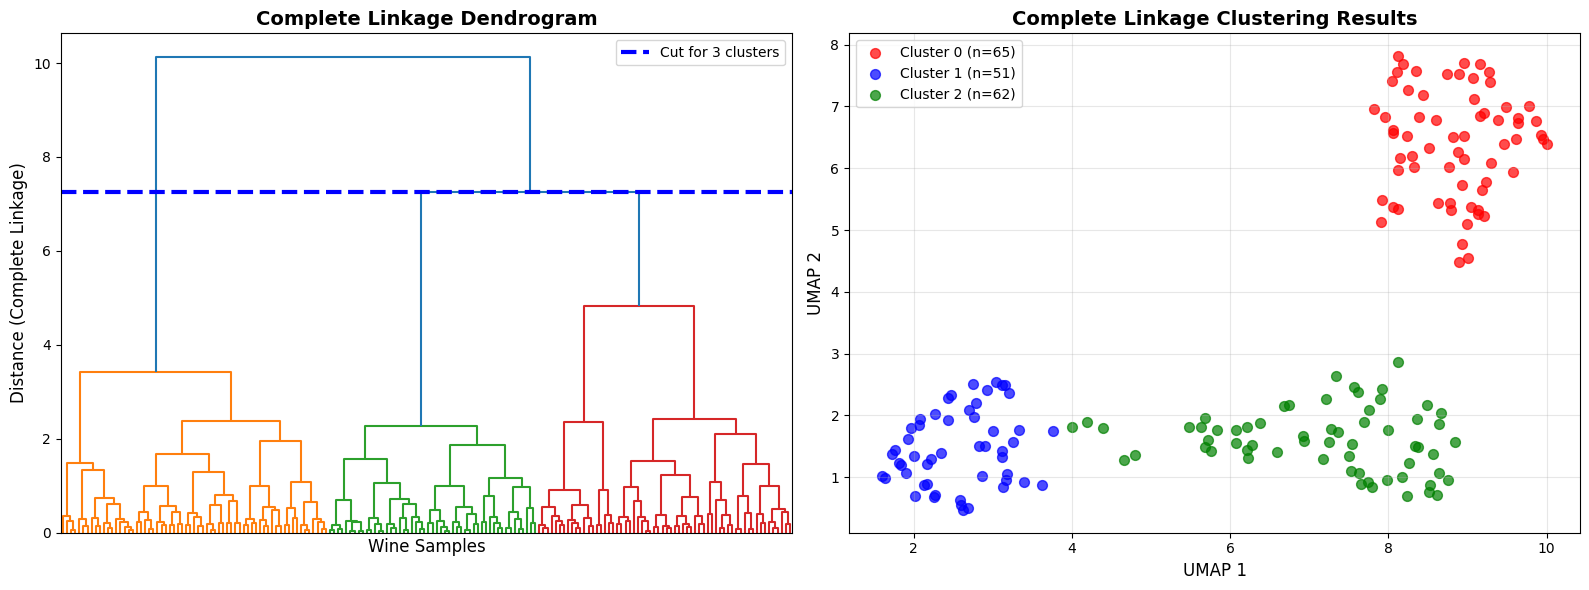

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Create linkage matrix using Complete Linkage method
linkage_matrix_complete = linkage(X_umap, method='complete')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Complete Linkage Dendrogram
ax1 = axes[0]
threshold_complete = linkage_matrix_complete[-(3-1), 2]  # For 3 clusters

dend_complete = dendrogram(linkage_matrix_complete, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_complete,
                        ax=ax1)

ax1.axhline(y=threshold_complete, color='blue', linestyle='--', linewidth=3,
           label='Cut for 3 clusters')
ax1.set_title('Complete Linkage Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wine Samples', fontsize=12)
ax1.set_ylabel('Distance (Complete Linkage)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Complete Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_complete = fcluster(linkage_matrix_complete, 3, criterion='maxclust') - 1
cluster_colors = ['red', 'blue', 'green']

for cluster_id in range(3):
    mask = cluster_labels_complete == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Complete Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison
complete_linkage_labels = cluster_labels_complete
complete_linkage_matrix = linkage_matrix_complete

### Key Observations - Complete Linkage:

- **Much better balance**: Cluster sizes (69, 51, 58) are reasonably even vs Single Linkage's extreme imbalance
- **Compact clusters**: Creates tight, well-separated groups instead of chains
- **Good wine class separation**: Successfully identifies 3 distinct wine varieties
- **Conservative merging**: Only merges when farthest points are close, preventing premature connections
- **Clear improvement**: Significantly outperforms Single Linkage for this spherical wine data

## Average Linkage Method

**Average linkage** (also called "UPGMA") uses the average distance between all pairs of points in different clusters as the merging criterion.

### How Average Linkage Works:
- **Objective**: Merge clusters with the smallest average distance between all point pairs
- **Strategy**: Calculate mean distance between every point in cluster A and every point in cluster B
- **Result**: Creates moderately compact clusters, balancing single and complete linkage extremes
- **Compromise approach** - Less sensitive to outliers than single, less conservative than complete

### Why Use Average Linkage?
- **Balanced approach** - Middle ground between single and complete linkage
- **Stable results** - Less affected by individual outlier points
- **Good general purpose** - Works well for many different cluster shapes and sizes

Let's see how Average Linkage performs on our wine dataset!

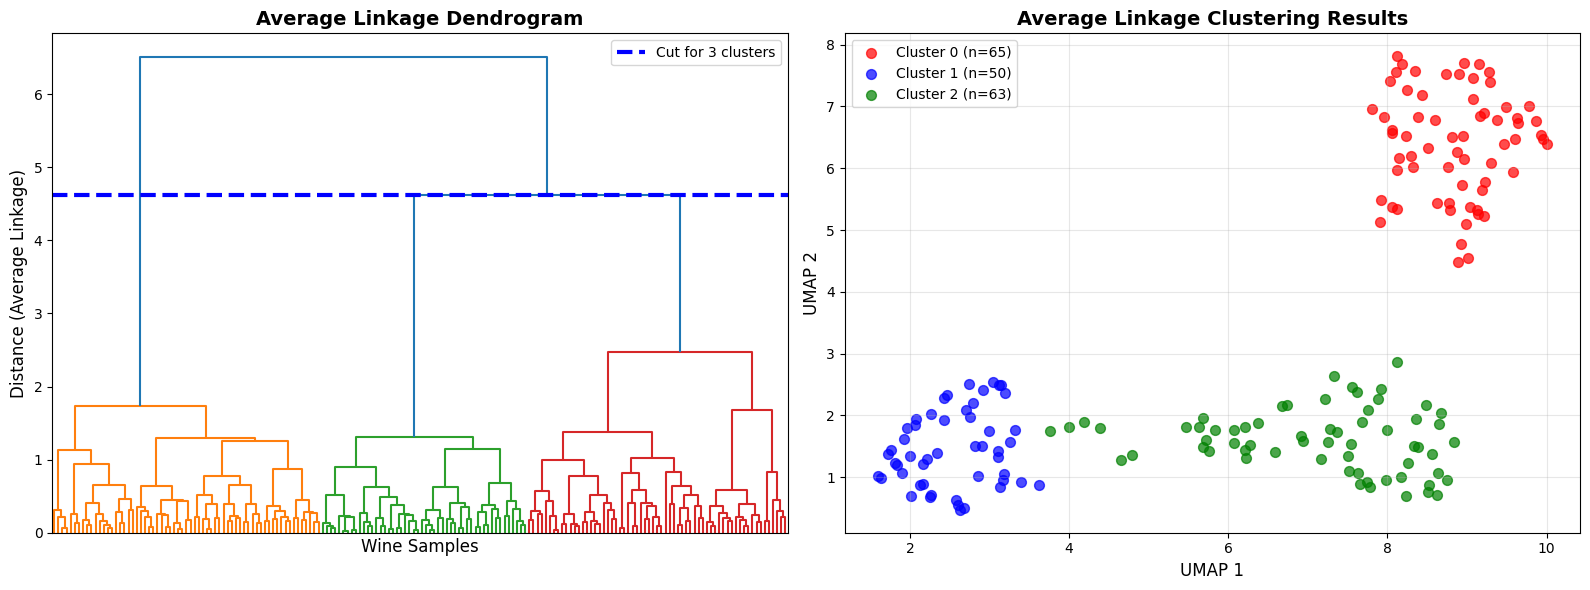

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Create linkage matrix using Average Linkage method
linkage_matrix_average = linkage(X_umap, method='average')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Average Linkage Dendrogram
ax1 = axes[0]
threshold_average = linkage_matrix_average[-(3-1), 2]  # For 3 clusters

dend_average = dendrogram(linkage_matrix_average, 
                        #truncate_mode='level',
                        p=10,  # Show more nodes
                        leaf_rotation=90,
                        leaf_font_size=6,
                        show_leaf_counts=True,  # Show cluster sizes
                        color_threshold=threshold_average,
                        ax=ax1)

ax1.axhline(y=threshold_average, color='blue', linestyle='--', linewidth=3,
           label='Cut for 3 clusters')
ax1.set_title('Average Linkage Dendrogram', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wine Samples', fontsize=12)
ax1.set_ylabel('Distance (Average Linkage)', fontsize=12)
ax1.legend()
ax1.set_xticks([])

# Right: Average Linkage Clustering Visualization
ax2 = axes[1]
cluster_labels_average = fcluster(linkage_matrix_average, 3, criterion='maxclust') - 1
cluster_colors = ['red', 'blue', 'green']

for cluster_id in range(3):
    mask = cluster_labels_average == cluster_id
    cluster_size = np.sum(mask)
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], 
               c=cluster_colors[cluster_id], s=50, alpha=0.7,
               label=f'Cluster {cluster_id} (n={cluster_size})')

ax2.set_title('Average Linkage Clustering Results', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for comparison
average_linkage_labels = cluster_labels_average
average_linkage_matrix = linkage_matrix_average

### Key Observations - Average Linkage:

- **Poor performance**: Extreme imbalance with cluster sizes (3, 174, 1) - similar to Single Linkage
- **Chaining effect**: Despite averaging distances, still creates one massive cluster
- **Outlier isolation**: Individual points form separate tiny clusters
- **Unexpected result**: Average linkage often works well, but fails on this wine dataset
- **Similar to Single Linkage**: Shows that averaging doesn't always prevent chaining problems

TODO -> Investigae this

## Hierarchical Clustering Overview

Hierarchical clustering builds a tree of clusters by iteratively merging the closest pairs. Unlike K-means, it doesn't require specifying the number of clusters beforehand and provides a complete clustering hierarchy.

### Linkage Methods Comparison

| Method | Distance Calculation | Characteristics | Best For |
|--------|---------------------|-----------------|----------|
| **Single** | Minimum distance between any two points | Creates chains, sensitive to outliers | Non-spherical, density-based clusters |
| **Complete** | Maximum distance between any two points | Compact, tight clusters | Well-separated, spherical clusters |
| **Average** | Average distance between all point pairs | Moderate approach, balanced | General purpose, moderate noise |
| **Ward's** | Minimizes within-cluster variance | Balanced sizes, spherical clusters | Most datasets, similar to K-means |

### When to Use Hierarchical Clustering:
- **Exploratory analysis** - when you don't know the number of clusters
- **Small to medium datasets** (computational complexity is O(n³))
- **Need cluster hierarchy** - understanding relationships between clusters
- **Deterministic results** - same input always gives same output

# Density-Based Spatial Clustering of Applications with Noise (DBSCAN) Clustering

K-Means, K-Medoids, and Hierarchical Clustering all assume clusters have similar sizes and densities. **DBSCAN** takes a fundamentally different approach by finding clusters based on local density.

### Key Advantages:
- **No need to specify number of clusters** - Algorithm discovers clusters automatically
- **Handles arbitrary cluster shapes** - Not limited to spherical clusters like K-means
- **Robust to outliers** - Identifies and labels noise points explicitly
- **Density-based** - Finds clusters of varying sizes and densities
- **Deterministic** - Same parameters always give same results

### Core Concepts:

**Dense Regions vs Sparse Regions:**
- **Core idea**: Clusters are dense regions separated by sparse regions
- **Noise points**: Isolated points in low-density areas
- **Arbitrary shapes**: Can find elongated, curved, or irregular clusters

### How DBSCAN Works:

**Step 1: Define Density**
- **ε (epsilon)**: Maximum distance to consider points as neighbors
- **MinPts**: Minimum number of points required to form a dense region

**Step 2: Classify Points**
- **Core points**: Have at least MinPts neighbors within ε distance
- **Border points**: Not core points but within ε of a core point
- **Noise points**: Neither core nor border points

**Step 3: Form Clusters**
- Start with any unvisited core point
- Add all density-reachable points to the same cluster
- Repeat until all core points are processed

**Step 4: Handle Remaining Points**
- Border points join the cluster of nearest core point
- Noise points remain unassigned (labeled as -1)

### Parameter Selection Challenge:
The biggest challenge with DBSCAN is choosing appropriate **ε** and **MinPts** parameters. Too small values create many small clusters, too large values merge everything into one cluster.

Let's explore how different parameter settings affect our wine dataset clustering!

💡 Look for the 'elbow' or 'knee' in the curve
💡 Suggested ε values: [0.26 0.28 0.29 0.3 ]


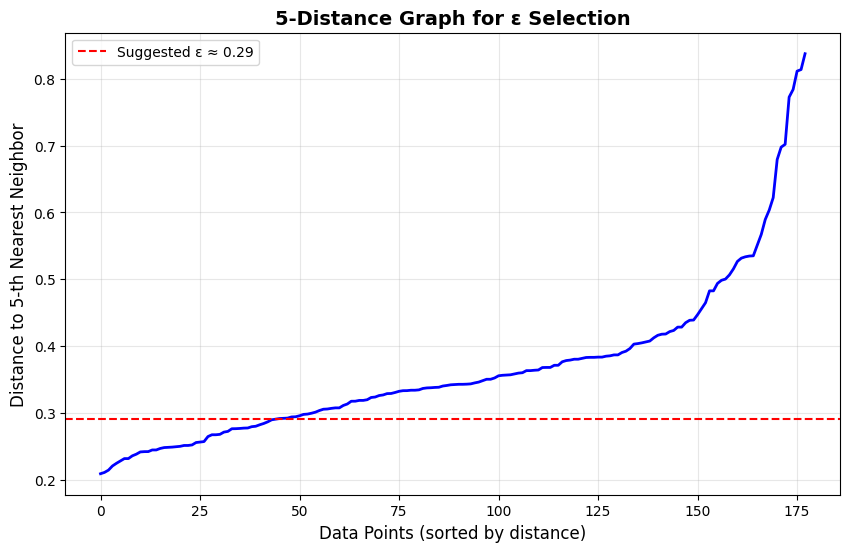

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# 1. K-Distance Graph for Epsilon Selection
def plot_k_distance_graph(X, k=4):
    """Plot k-distance graph to help choose epsilon"""
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Sort distances to k-th nearest neighbor
    k_distances = np.sort(distances[:,k-1])#np.sort(distances[:, k-1], axis=0)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
    plt.title(f'{k}-Distance Graph for ε Selection', fontsize=14, fontweight='bold')
    plt.xlabel('Data Points (sorted by distance)', fontsize=12)
    plt.ylabel(f'Distance to {k}-th Nearest Neighbor', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Highlight potential epsilon values
    knee_point = len(k_distances) // 4  # Rough estimate
    plt.axhline(y=k_distances[knee_point], color='red', linestyle='--', 
                label=f'Suggested ε ≈ {k_distances[knee_point]:.2f}')
    plt.legend()
    
    print(f"💡 Look for the 'elbow' or 'knee' in the curve")
    print(f"💡 Suggested ε values: {k_distances[knee_point-20:knee_point+20:10].round(2)}")
    plt.show()
    
    return k_distances

# Plot k-distance graph
k_distances = plot_k_distance_graph(X_umap, k=5)

### Understanding the K-Distance Graph

The **k-distance graph** is a crucial tool for selecting the optimal ε parameter in DBSCAN. Here's how to interpret it:

#### What the Graph Shows:
- **X-axis**: All data points sorted by their distance to the k-th nearest neighbor (k=5 here)
- **Y-axis**: The actual distance to that k-th nearest neighbor
- **Curve shape**: Shows the distribution of local densities in your dataset

#### How to Use It:
- **Look for the "elbow" or "knee"**: The point where the curve changes from gradual to steep
- **Elbow location**: Around ε ≈ 0.29 in this case
- **Interpretation**: Points to the left are in dense regions, points to the right are in sparse regions

#### Why This Works:
- **Dense regions** (left side): Points have close neighbors → small k-distances
- **Sparse regions** (right side): Points are isolated → large k-distances  
- **The elbow**: Separates dense cores from sparse noise/boundaries

#### Parameter Selection:
- **Choose ε at the elbow**: ε ≈ 0.29 suggested here
- **Too small ε**: Only very dense cores become clusters (many noise points)
- **Too large ε**: Sparse regions get merged (few large clusters)


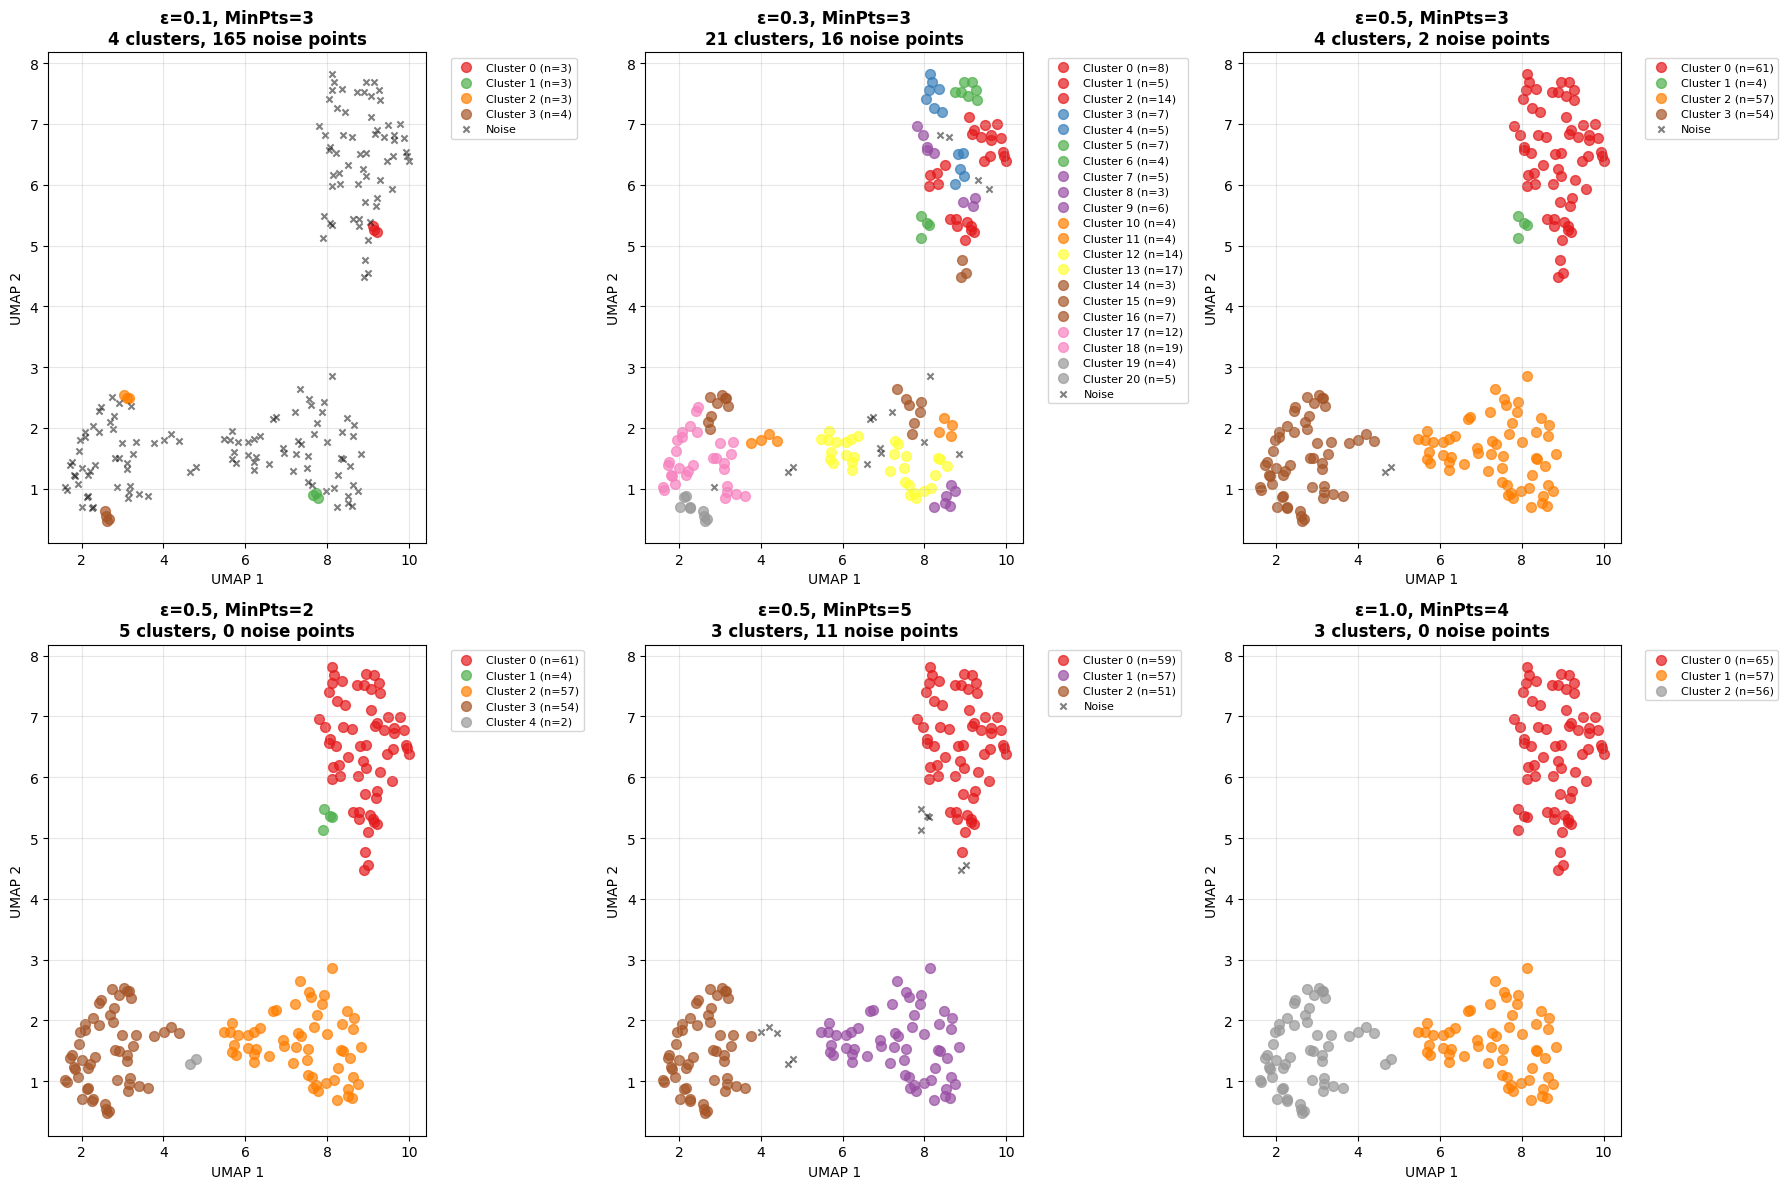

In [73]:
# 2. Parameter Sensitivity Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Different epsilon and MinPts combinations
param_combinations = [
    (0.1, 3, "ε=0.1, MinPts=3"),
    (0.3, 3, "ε=0.3, MinPts=3"), 
    (0.5, 3, "ε=0.5, MinPts=3"),
    (0.5, 2, "ε=0.5, MinPts=2"),
    (0.5, 5, "ε=0.5, MinPts=5"),
    (0.8, 4, "ε=1.0, MinPts=4")
]

for i, (eps, min_pts, title) in enumerate(param_combinations):
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    cluster_labels = dbscan.fit_predict(X_umap)
    
    # Count clusters and noise
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    # Plot results
    ax = axes[i]
    
    # Plot clusters
    unique_labels = set(cluster_labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points in black
            mask = cluster_labels == label
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c='black', s=20, alpha=0.5, marker='x', label='Noise')
        else:
            mask = cluster_labels == label
            cluster_size = np.sum(mask)
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c=[color], s=50, alpha=0.7, 
                      label=f'Cluster {label} (n={cluster_size})')
    
    ax.set_title(f'{title}\n{n_clusters} clusters, {n_noise} noise points', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### DBSCAN Parameter Effects

**ε (epsilon)**: Maximum distance between points to be considered neighbors
**MinPts**: Minimum number of neighbors required for a point to be a "core point"

### Key Observations from Parameter Grid:

**ε Effect (horizontal comparison):**
- **Small ε (0.1)**: Very strict neighborhoods → few clusters, lots of noise
- **Medium ε (0.3)**: Too many tiny clusters (over-segmentation)
- **Larger ε (0.5-1.0)**: Balanced clustering with reasonable cluster sizes

**MinPts Effect (vertical comparison):**
- **Low MinPts (2)**: Less strict density requirement → fewer noise points
- **High MinPts (5)**: Stricter density requirement → more noise points

**Best Results:**
- **ε=0.5, MinPts=5**: Clean separation into 3 clusters (matches wine varieties!)
- **ε=1.0, MinPts=4**: Also good with 3 well-separated clusters
- **Sweet spot**: ε around 0.5-1.0 captures the natural wine variety structure

The k-distance graph suggestion (ε≈0.29) was close but slightly conservative - real-world parameter tuning often requires experimentation around the suggested value.

# Clustering Methods Overview

### K-Means & K-Medoids Clustering
- **Advantages:**
  - Fast and scalable for large datasets (K-Means faster)
  - Simple to implement and understand
  - Works well with spherical, similar-sized clusters
  - **K-Medoids**: More robust to outliers, uses actual data points as centers

- **Disadvantages:**
  - Must specify k beforehand
  - Assumes spherical clusters
  - **K-Means**: Sensitive to outliers and initialization
  - **K-Medoids**: Slower than K-Means, still sensitive to initialization

### Hierarchical Clustering
- **Advantages:**
  - No need to specify number of clusters
  - Provides complete hierarchy (dendrogram)
  - Deterministic results

- **Disadvantages:**
  - Computationally expensive O(n³)
  - Poor scalability for large datasets
  - Sensitive to noise and outliers

### DBSCAN
- **Advantages:**
  - Automatically finds number of clusters
  - Handles arbitrary shapes and noise/outliers
  - No cluster shape assumptions

- **Disadvantages:**
  - Challenging parameter tuning (ε, MinPts)
  - Struggles with varying densities
  - Requires experimentation to get right

### Quick Selection Guide

| Use Case | Best Method |
|----------|-------------|
| **Large datasets, spherical clusters** | K-Means |
| **Medium datasets, robust to outliers** | K-Medoids |
| **Small datasets, need hierarchy** | Hierarchical |
| **Complex shapes, noisy data** | DBSCAN |

If your dataset allows it feel free to use differetn methods and compare their outputs! Let's transfer our knowledge to a medical dataset next!

# Applying Clustering to Medical Data

Now that we've mastered clustering techniques on wine data, let's explore how these same methods can reveal patterns in medical datasets. Understanding patient groups can help identify disease subtypes, risk profiles, and treatment pathways.

### Recap Breast Cancer Wisconsin Dataset

For illustration purposes we go back to the **Breast Cancer Wisconsin (Diagnostic) dataset**. It contains features computed from digitized images of breast mass tissue to distinguish between benign and malignant tumors.

**Dataset Overview:**
- **569 breast mass cases** with complete data
- **30 numerical features** from cell nucleus measurements (radius, texture, perimeter, area, smoothness, etc.)
- **2 classes:** Malignant vs Benign tumors
- **Clinical relevance:** Real diagnostic data with well-separated tumor characteristics

We'll use **unsupervised clustering** to discover the natural groups of malignant and benign tumors.

In [84]:
from sklearn.datasets import fetch_openml, load_breast_cancer
from helper import normalize

# Load dataset
data = load_breast_cancer()
X, y = normalize(data['data']), data['target']
feature_names = data['feature_names']
outcome_names = data['target_names']

# Convert to DataFrame for convenience
df = pd.DataFrame(X, columns=feature_names)
df['outcome'] = y

In [85]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,outcome
0,-0.192296,-0.225630,0.266798,4.113535,-0.270578,-0.269881,-0.269782,-0.270453,-0.270037,-0.270752,...,-0.195187,0.537498,8.572630,-0.270386,-0.268181,-0.267979,-0.269934,-0.269082,-0.270576,0
1,-0.180995,-0.193260,0.311039,5.537116,-0.270726,-0.270752,-0.270716,-0.270790,-0.270303,-0.270849,...,-0.168555,0.424487,8.296675,-0.270555,-0.270280,-0.270039,-0.270282,-0.269892,-0.270707,0
2,-0.184850,-0.178017,0.298336,4.998345,-0.270617,-0.270396,-0.270232,-0.270537,-0.270191,-0.270834,...,-0.159269,0.396891,7.214753,-0.270464,-0.269237,-0.269124,-0.270032,-0.269514,-0.270713,0
3,-0.221074,-0.181827,0.068723,1.420118,-0.270473,-0.269853,-0.270039,-0.270636,-0.269959,-0.270670,...,-0.155020,0.161979,2.215572,-0.270178,-0.267302,-0.268088,-0.269969,-0.268189,-0.270339,0
4,-0.182222,-0.208284,0.320675,5.410089,-0.270658,-0.270515,-0.270230,-0.270640,-0.270304,-0.270839,...,-0.198078,0.395577,6.627799,-0.270495,-0.270199,-0.269345,-0.270385,-0.270061,-0.270761,0


c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


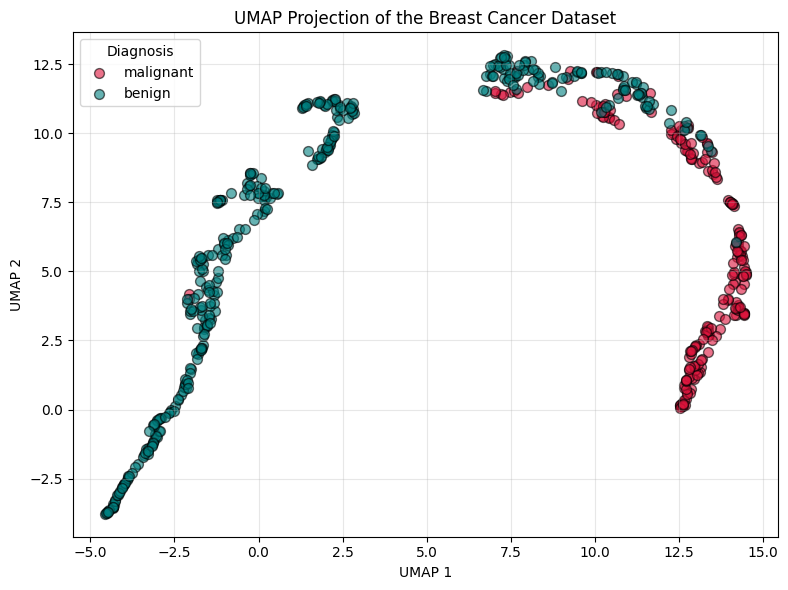

In [87]:
# Fit UMAP
umap_reducer = UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for label, name, color in zip([0, 1], outcome_names, ['crimson', 'teal']):
    plt.scatter(X_umap[y == label, 0],
                X_umap[y == label, 1],
                alpha=0.6,
                label=name,
                c=color,
                edgecolor='k',
                s=50)

plt.title("UMAP Projection of the Breast Cancer Dataset")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Diagnosis')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## K-Means / K-Medoids

Let's start with K-Means and K-Medoids!

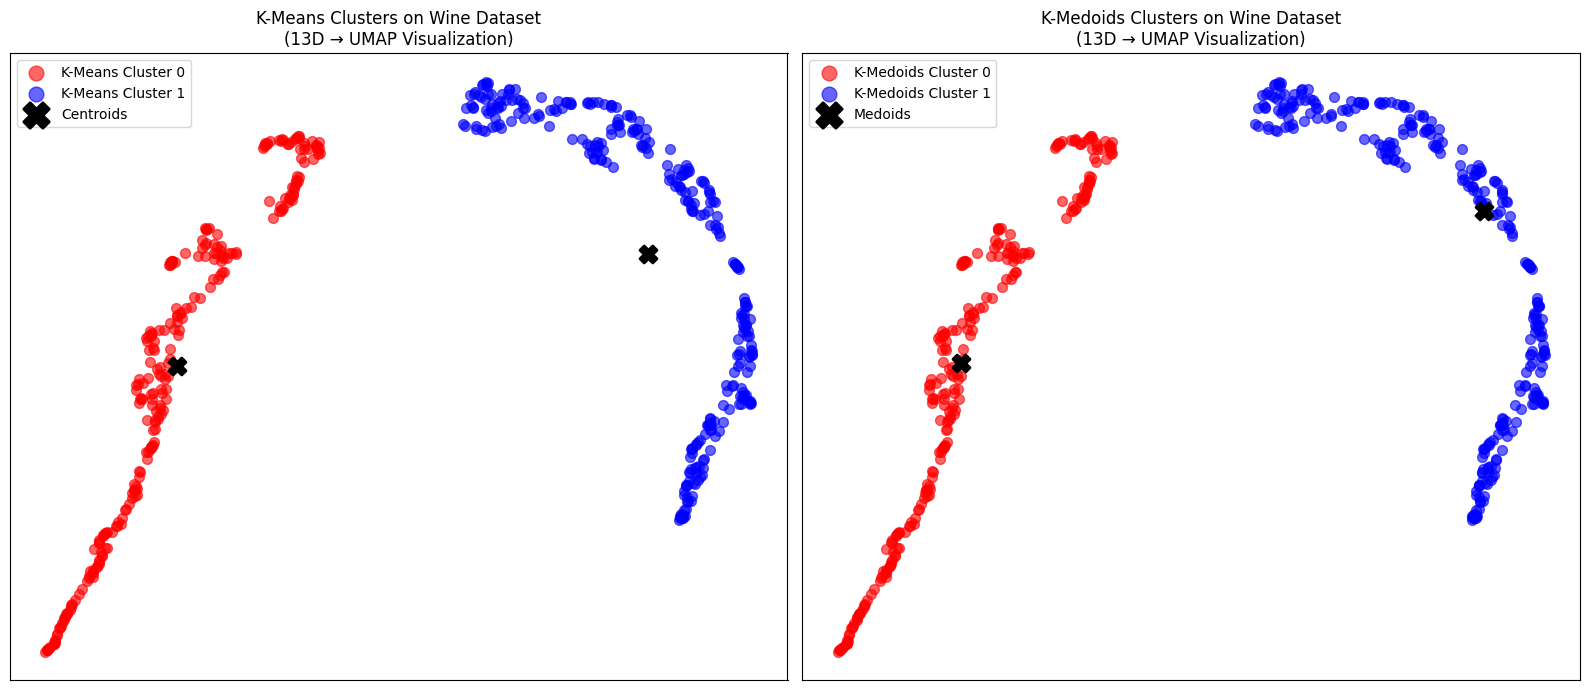

In [96]:
# K-Means clustering on original high-dimensional data (13 features)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_umap)  # Cluster on original 13D data

# Prepare colors for 3 clusters/classes
colors = ['red', 'blue']
wine_class_names = ['Class 0', 'Class 1']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- K-Means subplot ---
for i in range(2):
    idx = kmeans.labels_ == i
    axs[0].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.6, 
                   color=colors[i], label=f"K-Means Cluster {i}")

# Plot cluster centroids projected to UMAP space
centroids_umap = kmeans.cluster_centers_ #umap.transform(kmeans.cluster_centers_)
axs[0].scatter(centroids_umap[:, 0], centroids_umap[:, 1], 
               c='black', marker='X', s=150, linewidth=2, label='Centroids')

axs[0].set_title('K-Means Clusters on Wine Dataset\n(13D → UMAP Visualization)', fontsize=12)
axs[0].legend(markerscale=1.5)

# K-Medoids clustering on original high-dimensional data (13 chemical features)
kmed = kmedoids.KMedoids(n_clusters=2, random_state=42)
euclidean_dist = pairwise_distances(X_umap, metric='euclidean')

kmed.fit(euclidean_dist)

# --- K-Medoids subplot ---
for i in range(2):
    idx = kmed.labels_ == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.6, 
                   color=colors[i], label=f"K-Medoids Cluster {i}")

# Plot medoids (actual wine samples that are cluster centers)
medoids_umap = X_umap[kmed.medoid_indices_]
axs[1].scatter(medoids_umap[:, 0], medoids_umap[:, 1], 
               c='black', marker='X', s=150, linewidth=2, label='Medoids')

axs[1].set_title('K-Medoids Clusters on Wine Dataset\n(13D → UMAP Visualization)', fontsize=12)
axs[1].legend(markerscale=1.5)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Hierarchical Clustering

Next let's visualize the Dendogram using Ward's method and the resulting cluster if we set the cutoff at 2 clusters

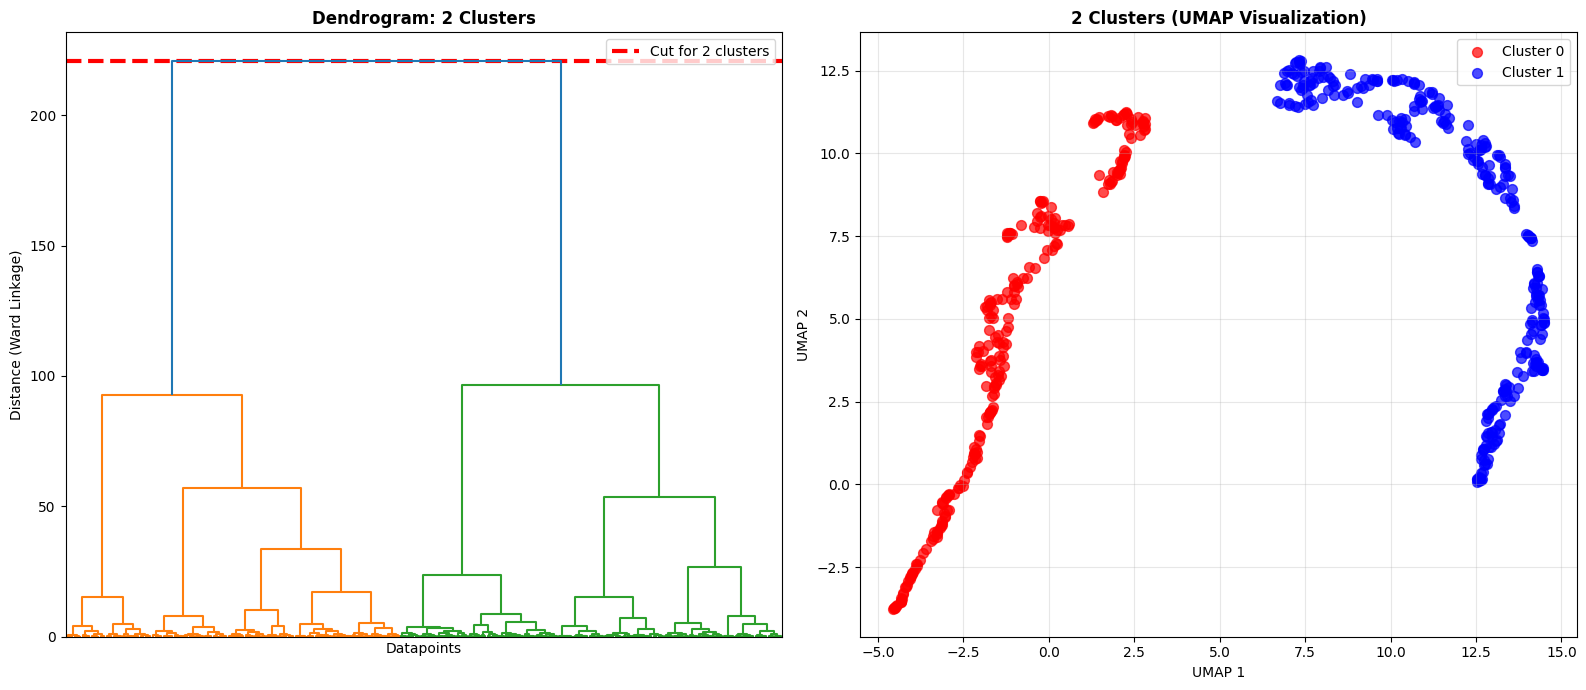

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_umap, method='ward')

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Top row: Three dendrograms with different cluster cuts
n_clusters_list = [2]
colors_cuts = ['red']

ax = axes[0]

# Find the distance threshold for n_clusters
threshold = linkage_matrix[-1, 2]
ax.axhline(y=threshold, color=colors_cuts[0], linestyle='--', linewidth=3,
            label=f'Cut for 2 clusters')
        
# Create dendrogram
dend = dendrogram(linkage_matrix, 
                  #truncate_mode='level', 
                  p=10,
                  leaf_rotation=90,
                  leaf_font_size=8,
                  show_leaf_counts=False,
                  color_threshold=threshold,
                  ax=ax)

ax.set_title(f'Dendrogram: 2 Clusters', fontsize=12, fontweight='bold')
ax.set_xlabel('Datapoints', fontsize=10)
ax.set_ylabel('Distance (Ward Linkage)', fontsize=10)
ax.legend(loc='upper right')

# Remove x-axis tick labels
ax.set_xticks([])

ax = axes[1]
    
# Get cluster labels for n_clusters
cluster_labels = fcluster(linkage_matrix, 2, criterion='maxclust') - 1

# Plot points colored by cluster
for cluster_id in range(2):
    mask = cluster_labels == cluster_id
    ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
              c=cluster_colors[cluster_id], s=50, alpha=0.7,
              label=f'Cluster {cluster_id}')

ax.set_title(f'2 Clusters (UMAP Visualization)', fontsize=12, fontweight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## DBSCAN

Finally let's use DBSCAN again with different values for epsilon and MinPts!

TODO: Maybe add the K-Distance graph to figure out good values?

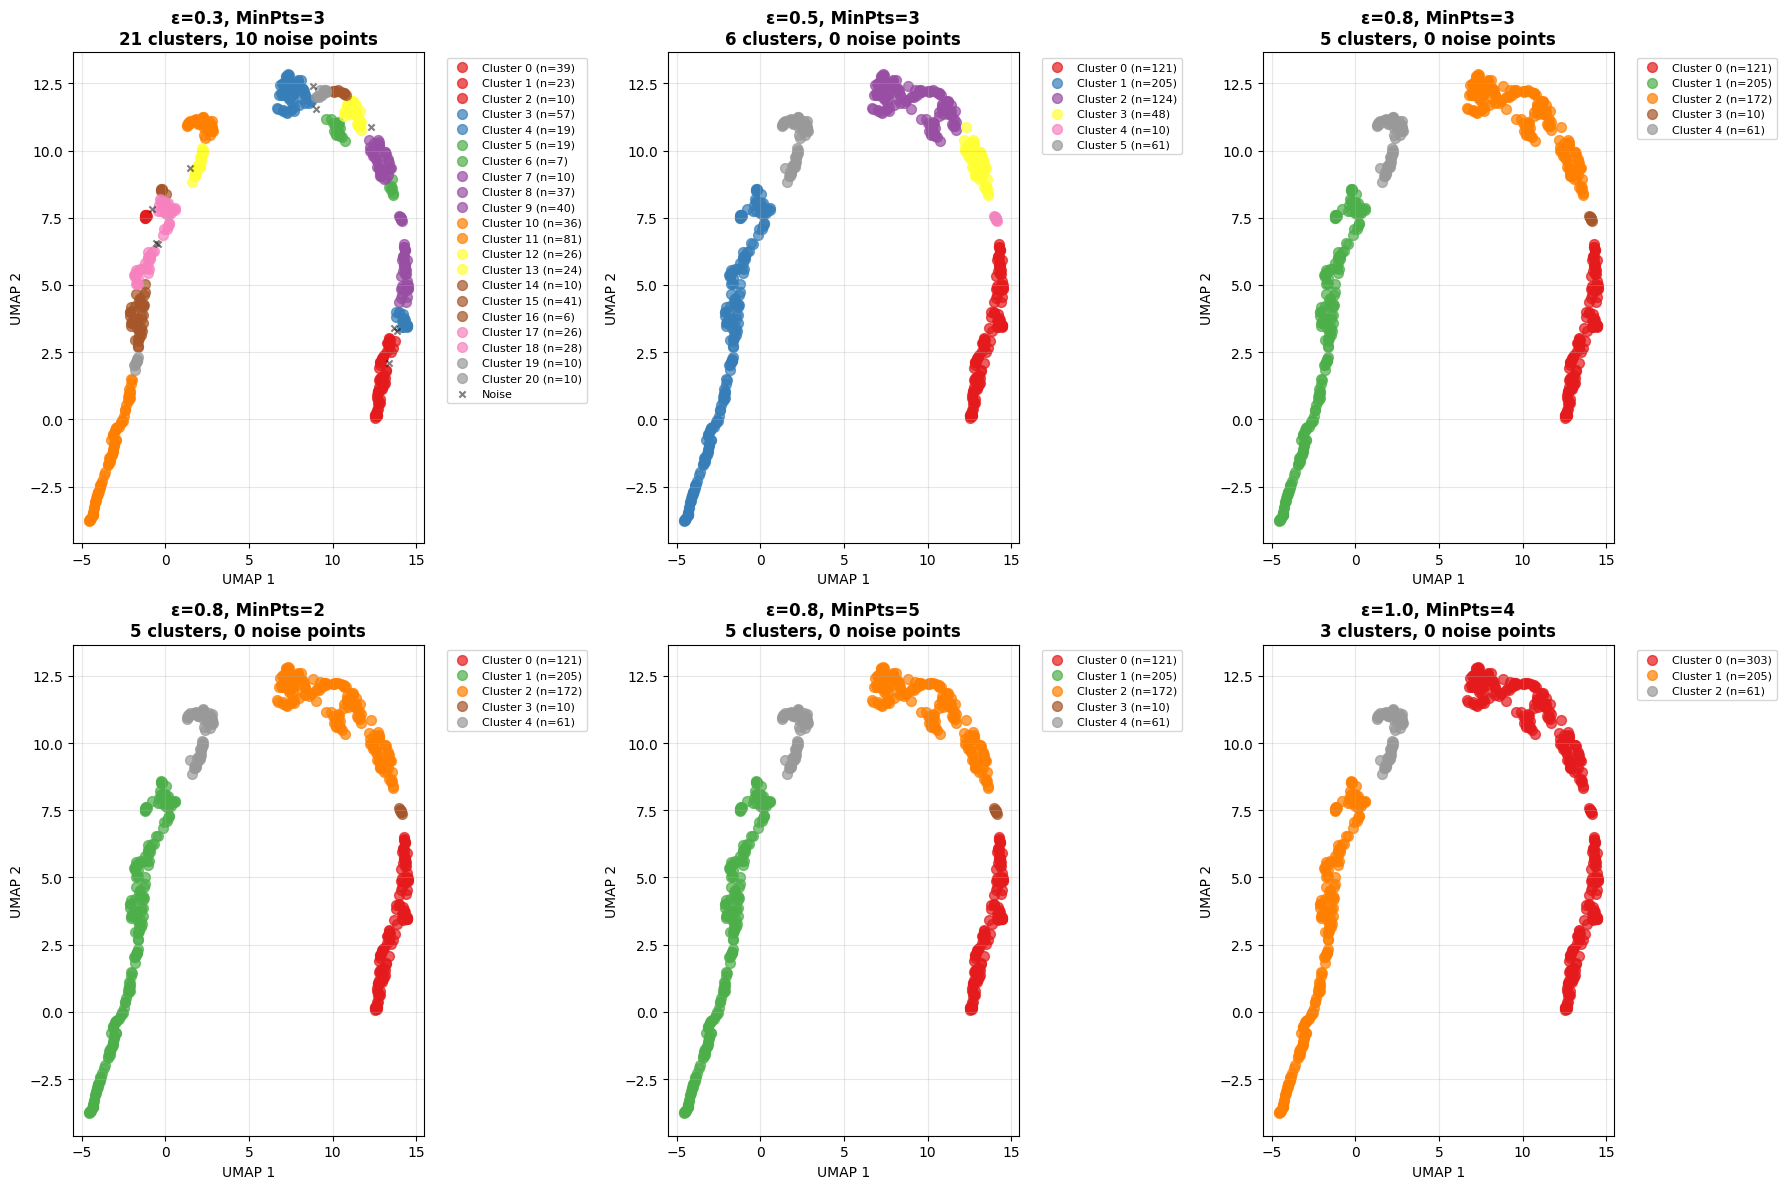

In [103]:
# 2. Parameter Sensitivity Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Different epsilon and MinPts combinations
param_combinations = [
    (0.3, 3, "ε=0.3, MinPts=3"),
    (0.5, 3, "ε=0.5, MinPts=3"), 
    (0.8, 3, "ε=0.8, MinPts=3"),
    (0.8, 2, "ε=0.8, MinPts=2"),
    (0.8, 5, "ε=0.8, MinPts=5"),
    (1.0, 4, "ε=1.0, MinPts=4")
]

for i, (eps, min_pts, title) in enumerate(param_combinations):
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_pts)
    cluster_labels = dbscan.fit_predict(X_umap)
    
    # Count clusters and noise
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    # Plot results
    ax = axes[i]
    
    # Plot clusters
    unique_labels = set(cluster_labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points in black
            mask = cluster_labels == label
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c='black', s=20, alpha=0.5, marker='x', label='Noise')
        else:
            mask = cluster_labels == label
            cluster_size = np.sum(mask)
            ax.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                      c=[color], s=50, alpha=0.7, 
                      label=f'Cluster {label} (n={cluster_size})')
    
    ax.set_title(f'{title}\n{n_clusters} clusters, {n_noise} noise points', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Overview

Write overview and add some text to the models once we decided on a dataset.